# Transcriptomics visualizations
Now that we've used R to get the differentially expressed genes, we can do some visualizations of what those look like for different comparisons.

In [104]:
from os import listdir
from os.path import splitext, abspath
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from tqdm import tqdm
from collections import defaultdict, Counter
import subprocess
import sys
sys.path.append('../utils/')
%load_ext autoreload
%autoreload 2
from get_arabidopsis_descriptions import get_arabidopsis_descriptions
from make_DEG_figure import makeDEGfigure
from plot_opposite_expression import plot_opposite_expression
from upsetplot import from_contents, plot, UpSet
import warnings
import json
import matplotlib.patches as mpatches

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read in the data

In [105]:
datapath = '../data/deseq2_output/'
time_comparisons = {}
o2_comparisons = {}
for f in listdir(datapath):
    name = '_'.join(f.split('_')[:4])
    if f.split('_')[1] == 'vs':
        time_comparisons[name] = pd.read_csv(datapath+f)
    elif f.split('_')[1] == 'o2':
        o2_comparisons[name] = pd.read_csv(datapath+f)

In [106]:
time_comparisons.keys(), o2_comparisons.keys()

(dict_keys(['1h_vs_7h_2o2', '1h_vs_7h_40o2', '1h_vs_7h_21o2']),
 dict_keys(['1h_o2_40_21', '7h_o2_2_21', '1h_o2_2_21', '7h_o2_40_21']))

Order the dictionaries by a sensible order for plotting:

In [107]:
time_comparisons = {k: time_comparisons[k] for k in ['1h_vs_7h_21o2', '1h_vs_7h_2o2', '1h_vs_7h_40o2']}
o2_comparisons = {k: o2_comparisons[k] for k in ['1h_o2_2_21', '1h_o2_40_21', '7h_o2_2_21', '7h_o2_40_21']}

Define the semantic names to be used in the plots:

In [108]:
conditions_semantic = {
    '1h_vs_7h_2o2': '7 hours vs. 1 hour at 2% oxygen',
    '1h_vs_7h_40o2': '7 hours vs. 1 hour at 40% oxygen',
    '1h_vs_7h_21o2': '7 hours vs. 1 hour at 21% oxygen',
    '1h_o2_40_21': '40% vs. 21% oxygen at 1 hour',
    '7h_o2_2_21': '2% vs. 21% oxygen at 7 hours',
    '1h_o2_2_21': '2% vs. 21% oxygen at 1 hour',
    '7h_o2_40_21': '40% vs. 21% oxygen at 7 hours'
}
reverse_condition_semantic = {v: k for k, v in conditions_semantic.items()}

## Time comparisons
First, let's take a look at the distributions of the log fold change for the 1 hour vs. 7 hour comparisons.

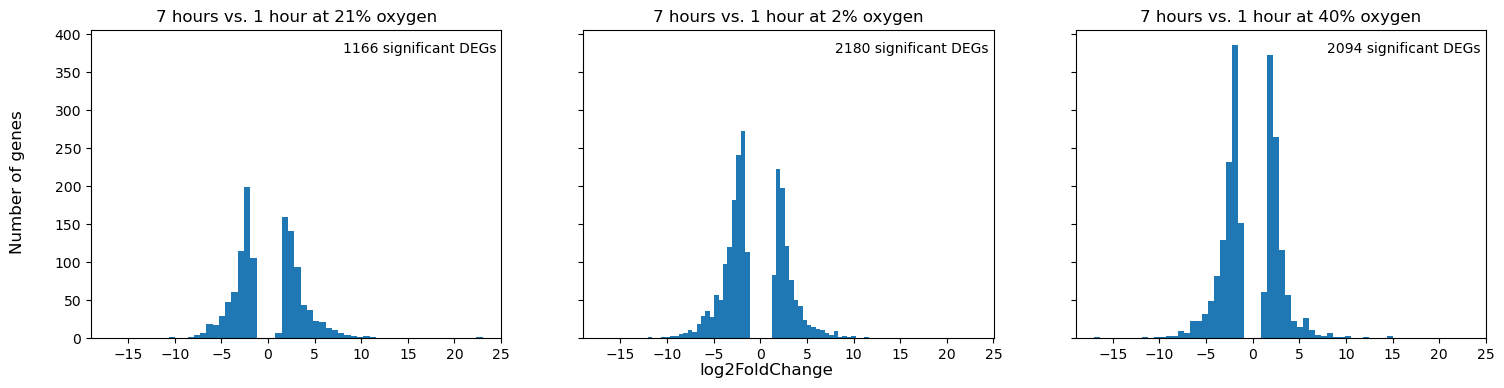

In [109]:
fig, axs = plt.subplots(1, len(time_comparisons), sharex=True, sharey=True, figsize=(len(time_comparisons)*6, 4))

for ax, comp in zip(axs, time_comparisons):
    ax.hist(time_comparisons[comp].log2FoldChange, bins=50)
    ax.set_title(conditions_semantic[comp])
    ax.text(8, 375, f'{len(time_comparisons[comp])} significant DEGs')
fig.supxlabel('log2FoldChange')
fig.supylabel('Number of genes', x=0.08)
plt.savefig('../data/figures/degs_time_unfiltered.png', format='png', dpi=600, bbox_inches='tight')

The presence of so many DEGs after 7 hours at ambient oxygen to me indicates that many of the DEGs we're seeing in the other conditions aren't related to the change in photorespiration as induced by the change in oxygen, but rather normal processed that change over the course of a day. What happens to these distributions if we remove the DEGs from 2% and 40% that are also found with the same directional change in 21%?

In [110]:
two_21_merged = pd.merge(time_comparisons['1h_vs_7h_2o2'], time_comparisons['1h_vs_7h_21o2'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_21o2'))
two_to_drop = two_21_merged[two_21_merged.log2FoldChange_2o2 * two_21_merged.log2FoldChange_21o2 > 0].gene_id
two_filtered_by_21 = time_comparisons['1h_vs_7h_2o2'][~time_comparisons['1h_vs_7h_2o2'].gene_id.isin(two_to_drop)].reset_index(drop=True)
two_filtered_by_21.shape

(1492, 7)

In [111]:
forty_21_merged = pd.merge(time_comparisons['1h_vs_7h_40o2'], time_comparisons['1h_vs_7h_21o2'], left_on='gene_id', right_on='gene_id', suffixes=('_40o2', '_21o2'))
forty_to_drop = forty_21_merged[forty_21_merged.log2FoldChange_40o2 * forty_21_merged.log2FoldChange_21o2 > 0].gene_id
forty_filtered_by_21 = time_comparisons['1h_vs_7h_40o2'][~time_comparisons['1h_vs_7h_40o2'].gene_id.isin(forty_to_drop)].reset_index(drop=True)
forty_filtered_by_21.shape

(1280, 7)

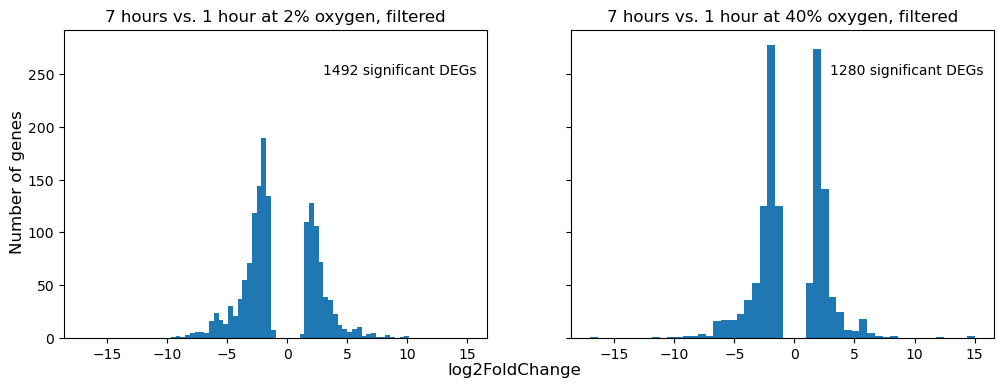

In [112]:
comps_filtered = {
    '7 hours vs. 1 hour at 2% oxygen, filtered': two_filtered_by_21,
    '7 hours vs. 1 hour at 40% oxygen, filtered': forty_filtered_by_21
}
fig, axs = plt.subplots(1, len(comps_filtered), sharex=True, sharey=True, figsize=(len(comps_filtered)*6, 4))

for ax, comp in zip(axs, comps_filtered):
    ax.hist(comps_filtered[comp].log2FoldChange, bins=50)
    ax.set_title(comp)
    ax.text(3, 250, f'{len(comps_filtered[comp])} significant DEGs')
fig.supxlabel('log2FoldChange')
fig.supylabel('Number of genes', x=0.08)
plt.savefig('../data/figures/degs_time_filtered.png', format='png', dpi=600, bbox_inches='tight')

That substantially reduces the number of genes we're interested in looking at. 

Export the filtered sets:

In [113]:
two_filtered_by_21.to_csv('../data/deseq2_filtered/2_o2_7h_v_1h_filtered.csv', index=False)
forty_filtered_by_21.to_csv('../data/deseq2_filtered/40_o2_7h_v_1h_filtered.csv', index=False)

Generally speaking, we are interested in genes that have opposite responses at 2% vs. 40% oxygen, as the photorespiratory demands of those two conditions are opposite. Let's take a look at what genes fit that description for the hour comparisons:

In [114]:
two_forty = pd.merge(two_filtered_by_21, forty_filtered_by_21, left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))

In [115]:
opposites_hour = two_forty[two_forty['log2FoldChange_2o2']*two_forty['log2FoldChange_40o2'] < 0]
opposites_hour.shape

(12, 13)

That gives us 12 genes, which is a very manageable number! Save them out, using the [Araport11 functional annotations](https://www.arabidopsis.org/download/Subscriber_Data_Releases/TAIR_Data_20241231/Araport11_functional_descriptions_20241231.txt.gz):

In [116]:
annotation_metadata = {
    'Araport11': '../data/external_data/Araport11_functional_descriptions_20241231.txt',
    'TAIR10': '../data/external_data/TAIR10_functional_descriptions_20130831.txt'
}
opposites_over_time = get_arabidopsis_descriptions(opposites_hour.gene_id.tolist(), annotation_metadata)
opposites_over_time.to_csv('../data/gene_lists_with_descriptions/time_comparison_opposites_Araport11_TAIR10_19Mar2025.csv', index=True)

Visualization with arrows:

In [117]:
# Normalize between -1 and 1
time_opps_all = opposites_hour.log2FoldChange_2o2.tolist() + opposites_hour.log2FoldChange_40o2.tolist()
time_opps_norm_denom = max(time_opps_all) - min(time_opps_all)
opposites_hour.loc[:,'log2FoldChange_2o2_NORMALIZED'] = 2*((opposites_hour['log2FoldChange_2o2'] - min(time_opps_all)) / time_opps_norm_denom) - 1
opposites_hour.loc[:,'log2FoldChange_40o2_NORMALIZED'] = 2*((opposites_hour['log2FoldChange_40o2'] - min(time_opps_all)) / time_opps_norm_denom) - 1
opposites_hour = opposites_hour.reset_index(drop=True)
time_cols = {
    'Expression at 2%': 'log2FoldChange_2o2_NORMALIZED',
    'Expression at 40%': 'log2FoldChange_40o2_NORMALIZED'
}

/tmp/local/52532927/ipykernel_2799174/425582070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opposites_hour.loc[:,'log2FoldChange_2o2_NORMALIZED'] = 2*((opposites_hour['log2FoldChange_2o2'] - min(time_opps_all)) / time_opps_norm_denom) - 1
/tmp/local/52532927/ipykernel_2799174/425582070.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opposites_hour.loc[:,'log2FoldChange_40o2_NORMALIZED'] = 2*((opposites_hour['log2FoldChange_40o2'] - min(time_opps_all)) / time_opps_norm_denom) - 1


Read in a mapping between TAIR ID's and more useful gene names:

In [118]:
ara = pd.read_csv('../data/external_data/gene_aliases_20241231.txt', sep='\t', header=0, encoding='Windows-1252')
tair2gene = {k: v for k, v in ara.set_index('locus_name')[['symbol']].to_dict()['symbol'].items()}

Now plot:

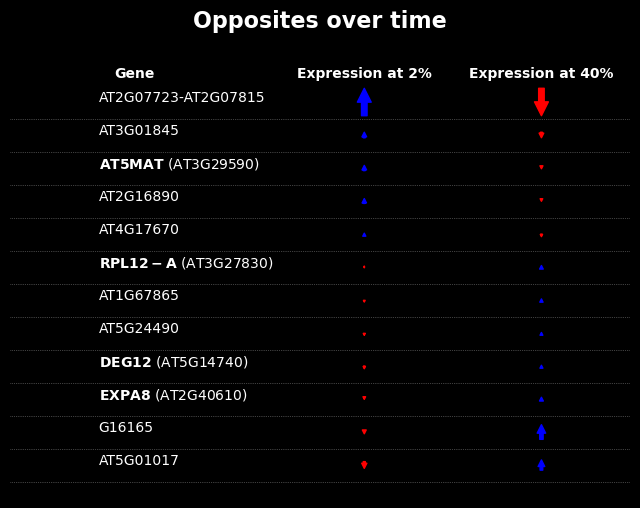

In [119]:
plot_opposite_expression(opposites_hour, time_cols, gene_name_map=tair2gene, scale_factor=20, title='Opposites over time', dark=True)
plt.savefig('../data/figures/opposite_expression_time_DARK_24Mar2025.png', bbox_inches='tight', dpi=600, format='png')

## Oxygen comparisons
Before we dive into the time comparison opposite behavior genes, let's look at the comparisons of each oxygen level at the two timepoints. We can then cross-reference the genes of interest that we find in order to narrow down our list even further. Let's start with the same basic visualizations as we did for the time comparisons:

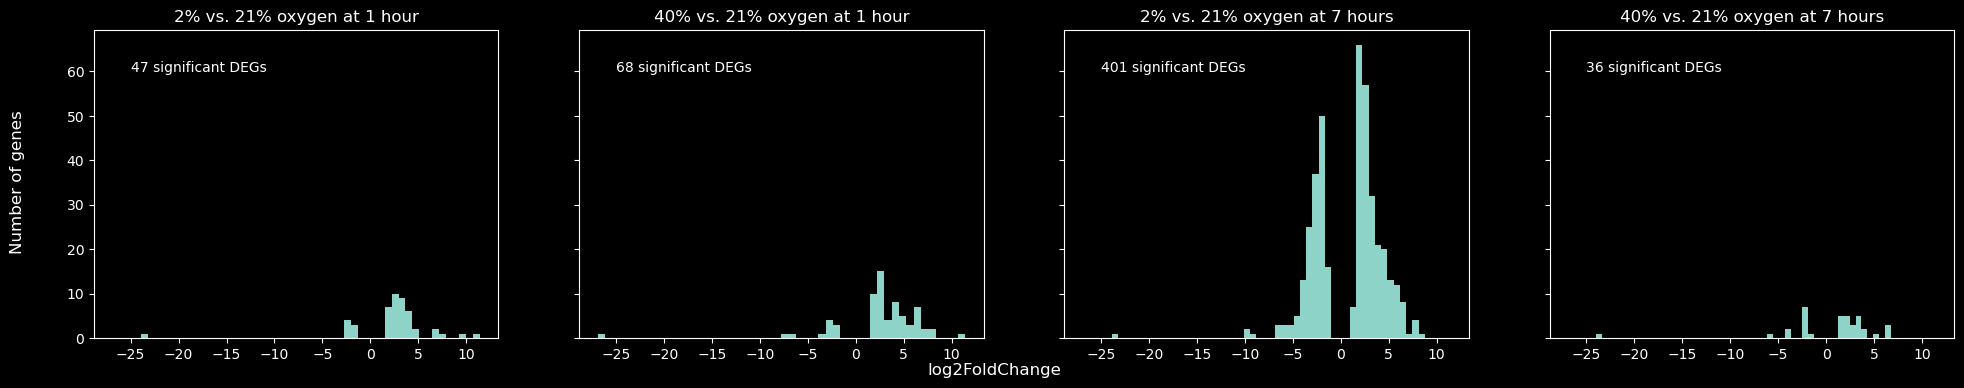

In [120]:
fig, axs = plt.subplots(1, len(o2_comparisons), sharex=True, sharey=True, figsize=(len(o2_comparisons)*6, 4))

for ax, comp in zip(axs, o2_comparisons):
    ax.hist(o2_comparisons[comp].log2FoldChange, bins=50)
    ax.set_title(conditions_semantic[comp])
    ax.text(-25, 60, f'{len(o2_comparisons[comp])} significant DEGs')
fig.supylabel('Number of genes', x=0.09)
fig.supxlabel('log2FoldChange')
plt.savefig('../data/figures/degs_o2.png', format='png', dpi=600, bbox_inches='tight')

Now this is interesting; we have much more skewed distributions for these comparisons, and there are many fewer genes being differentially expressed in these comparisons. Interestingly, note that there are substantially more DEGs at 7 hours in the 2% samples; this is the condition that showed a return to ambient levels of phi2. As before, we're interested in genes that have opposite behaviors between 2% and 40%; abut I am also now curious about the large number of DEGs in 2% at 7 hours.

For the time comparisons, we made the assumption that DEGs at 21% oxygen that appeared in the 2% or 40% treatments could be removed because we're interested in the differences from the ambient condition. Similarly here, we could make the assumption that the 1 hour time point is more or less the same as ambient and remove those genes from the 7 hour timepoints. However, given that the oxygen groupings separated on the PCA at 1 hour, I am not sure this is a valid assumption. To put that assumption to the test, let's see how many DEGs are in common between the oxygen comparisons at 1 hour, regardless of their directionality. If the 1 hour timepoint isn't meaningful biologically, then I would expect that most of the DEGs are in common between the two conditions.

In [121]:
shared = set(o2_comparisons['1h_o2_2_21'].gene_id).intersection(o2_comparisons['1h_o2_40_21'].gene_id)
print(f'There are {len(shared)} genes in common  between the oxygen conditions at 1 hour. This represents {(len(shared)/len(o2_comparisons["1h_o2_2_21"]))*100:.2f}% '
     f'of the total DEGs for 2% oxygen at 1 hour, and {(len(shared)/len(o2_comparisons["1h_o2_40_21"]))*100:.2f}%  of the total DEGs for 40% oxygen at 1 hour.')

There are 15 genes in common  between the oxygen conditions at 1 hour. This represents 31.91% of the total DEGs for 2% oxygen at 1 hour, and 22.06%  of the total DEGs for 40% oxygen at 1 hour.


Ok so a reasonable proportion of them are in common (at least from the perspective of presence/absence), but it's less than 1/3rd for both conditions. I am therefore going to treat the 1 hour condition as having biologically meaningful expression differences as induced by the changes in oxygen. We'll therefore look at the genes that have opposite behaviors between the oxygen conditions for both timepoints separately, and then we can dig in and see if any of those DEGs are the same for the two timepoints in a given condition (the thought being that maybe something that starts having differential expression at 1 hour has stronger differential expression at 7 hours).

In [122]:
hour1 = pd.merge(o2_comparisons['1h_o2_2_21'], o2_comparisons['1h_o2_40_21'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))
opposites_hour1 = hour1[hour1['log2FoldChange_2o2']*hour1['log2FoldChange_40o2'] < 0]

In [123]:
hour7 = pd.merge(o2_comparisons['7h_o2_2_21'], o2_comparisons['7h_o2_40_21'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))
opposites_hour7 = hour7[hour7['log2FoldChange_2o2']*hour7['log2FoldChange_40o2'] < 0]

In [124]:
print(f'There are {len(opposites_hour1)} opposite-behavior DEGs at 1 hour, and {len(opposites_hour7)} at 7 hours.')

There are 0 opposite-behavior DEGs at 1 hour, and 5 at 7 hours.


That is way fewer than I expected! Firstly, this means that the genes in common between the two conditions at hour 1 are both regulated in the same direction. This actually supports the idea that there is not much biologically meaningful going on at 1 hour that's caused by the changes in oxygen; however, this analysis doesn't account for the greater portion of genes that the two conditions don't have in common. Save them out:

In [125]:
hour7_descriptions = get_arabidopsis_descriptions(opposites_hour7.gene_id.tolist(), annotation_metadata)
hour7_descriptions.to_csv('../data/gene_lists_with_descriptions/hour7_opposite_behavior_genes_Araport11_TAIR10_19Mar2025.csv', index=True)

Let's visualize the 5 opposite genes with arrows. First, let's prepare the data:

In [126]:
# Normalize between -1 and 1
hour7_opps_all = opposites_hour7.log2FoldChange_2o2.tolist() + opposites_hour7.log2FoldChange_40o2.tolist()
hour7_opps_norm_denom = max(hour7_opps_all) - min(hour7_opps_all)
opposites_hour7.loc[:,'log2FoldChange_2o2_NORMALIZED'] = 2*((opposites_hour7['log2FoldChange_2o2'] - min(hour7_opps_all)) / hour7_opps_norm_denom) - 1
opposites_hour7.loc[:,'log2FoldChange_40o2_NORMALIZED'] = 2*((opposites_hour7['log2FoldChange_40o2'] - min(hour7_opps_all)) / hour7_opps_norm_denom) - 1
opposites_hour7 = opposites_hour7.reset_index(drop=True)

/tmp/local/52532927/ipykernel_2799174/1675695836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opposites_hour7.loc[:,'log2FoldChange_2o2_NORMALIZED'] = 2*((opposites_hour7['log2FoldChange_2o2'] - min(hour7_opps_all)) / hour7_opps_norm_denom) - 1
/tmp/local/52532927/ipykernel_2799174/1675695836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opposites_hour7.loc[:,'log2FoldChange_40o2_NORMALIZED'] = 2*((opposites_hour7['log2FoldChange_40o2'] - min(hour7_opps_all)) / hour7_opps_norm_denom) - 1


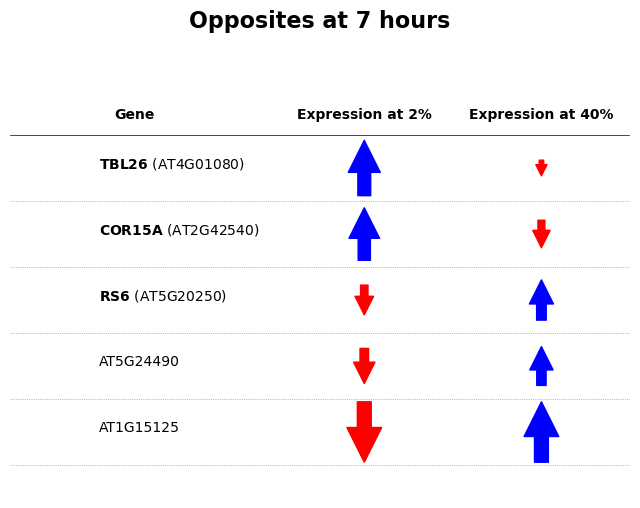

In [127]:
plot_opposite_expression(opposites_hour7, time_cols, gene_name_map=tair2gene, title='Opposites at 7 hours')
plt.savefig('../data/figures/opposite_expression_7ho2_24Mar2025.png', bbox_inches='tight', dpi=600, format='png')

## Visualization of set overlaps
We can use UpSet plots to visualize our results better across all sets. We'll make two separate plots for the time and the oxygen comparisons for visual simplicity.

In [128]:
genes_in_time_comps = {}
for comp, df in time_comparisons.items():
    genes_in_time_comps[conditions_semantic[comp]] = list(set(df.gene_id.tolist()))

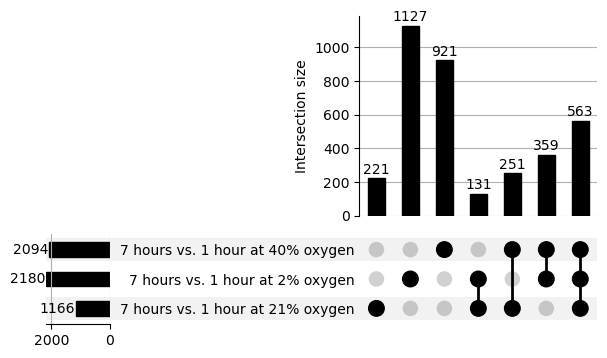

In [129]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(genes_in_time_comps)
plot(to_plot, show_counts=True, sort_categories_by='input')
plt.savefig('../data/figures/degs_time_unfiltered_UPSET.png', format='png', dpi=600, bbox_inches='tight')

We also want to look at the filtered time comparisons, which means we should remove 21%, as that's what we used to remove genes that were potentially involved in circadian responses:

In [130]:
comps_filtered = {
    '7 vs. 1 h at 2% oxygen, filtered': two_filtered_by_21,
    '7 vs. 1 h at 40% oxygen, filtered': forty_filtered_by_21
}

genes_in_time_comps_filtered = {}
for comp, df in comps_filtered.items():
    genes_in_time_comps_filtered[comp] = list(set(df.gene_id.tolist()))

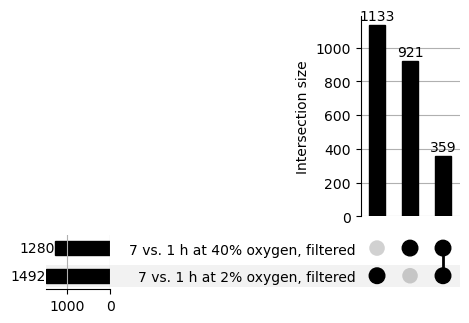

In [131]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(genes_in_time_comps_filtered)
plot(to_plot, show_counts=True, sort_categories_by='input')
plt.savefig('../data/figures/degs_time_filtered_UPSET.png', format='png', dpi=600, bbox_inches='tight')

There are 359 genes that remain in common between the two treatments once they're filtered for circadian expression. If we look in just that set for oppositely expressed genes, what do we see?

In [132]:
genes_in_o2_comps = {}
for comp, df in o2_comparisons.items():
    genes_in_o2_comps[conditions_semantic[comp]] = list(set(df.gene_id.tolist()))

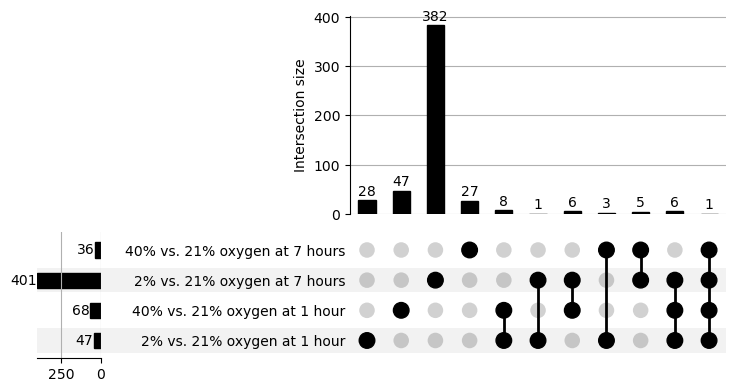

In [133]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(genes_in_o2_comps)
plot(to_plot, show_counts=True, sort_categories_by='input')
plt.savefig('../data/figures/degs_o2_UPSET.png', format='png', dpi=600, bbox_inches='tight')

We might expect that genes that are important in retoring phi2 are differentially expressed in 2% oxygen over time and also in 2% oxygen at 7 hours. Let's make an upset plot for each of the oxygen concentrations as well, to look for this overlap:

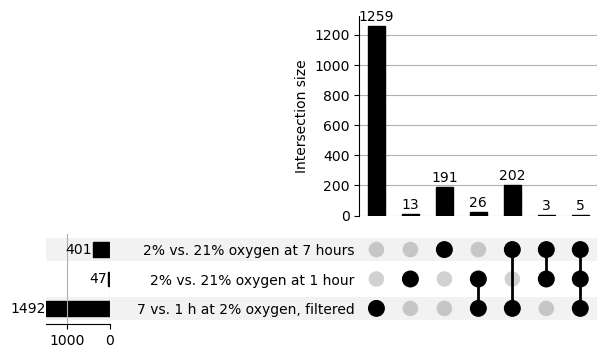

In [135]:
two_comps = {
    '7 vs. 1 h at 2% oxygen, filtered': two_filtered_by_21.gene_id.tolist(),
    '2% vs. 21% oxygen at 1 hour': genes_in_o2_comps['2% vs. 21% oxygen at 1 hour'],
    '2% vs. 21% oxygen at 7 hours': genes_in_o2_comps['2% vs. 21% oxygen at 7 hours']
}
warnings.filterwarnings('ignore')
to_plot = from_contents(two_comps)
plot(to_plot, show_counts=True, sort_categories_by='input')
plt.savefig('../data/figures/degs_2o2_all_UPSET.png', format='png', dpi=600, bbox_inches='tight')

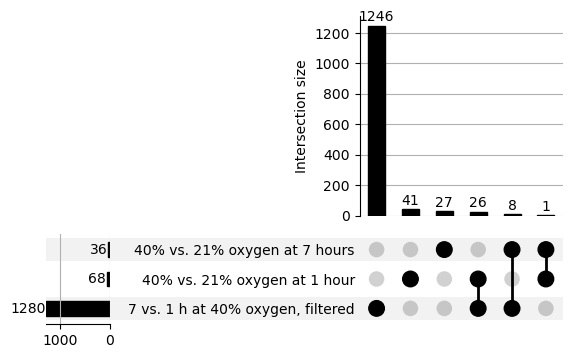

In [27]:
forty_comps = {
    '7 vs. 1 h at 40% oxygen, filtered': forty_filtered_by_21.gene_id.tolist(),
    '40% vs. 21% oxygen at 1 hour': genes_in_o2_comps['40% vs. 21% oxygen at 1 hour'],
    '40% vs. 21% oxygen at 7 hours': genes_in_o2_comps['40% vs. 21% oxygen at 7 hours']
}
warnings.filterwarnings('ignore') 
to_plot = from_contents(forty_comps)
plot(to_plot, show_counts=True, sort_categories_by='input')
plt.savefig('../data/figures/degs_40o2_all_UPSET.png', format='png', dpi=600, bbox_inches='tight')

We want to save out the time/7ho2 overlaps to be able to look at them in more detail and to do a GO enrichment:

In [28]:
# Includes both genes that only overlap between 7h and time, as well as those between all three 2% comparisons
two_overlap = set(two_comps['2% vs. 21% oxygen at 7 hours']).intersection(set(two_comps['7 vs. 1 h at 2% oxygen, filtered']))
with open('../data/gene_lists/2o2_all_comps_overlaps_gene_list.txt', 'w') as f:
    f.write('\n'.join(two_overlap))

In [29]:
forty_overlap = set(forty_comps['40% vs. 21% oxygen at 7 hours']).intersection(set(forty_comps['7 vs. 1 h at 40% oxygen, filtered']))
with open('../data/gene_lists/40o2_all_comps_overlaps_gene_list.txt', 'w') as f:
    f.write('\n'.join(forty_overlap))

## Time and Oxygen
There are also substantially fewer genes with opposite behavior at the 7 hour time point. Are any of these in common with our opposite behavior genes from the time comparison?

In [30]:
all_opposite = set(opposites_hour.gene_id).intersection(set(opposites_hour7.gene_id))
all_opposite

{'AT5G24490'}

Only one is in common; what is this gene? According to the [GO annotations in TAIR for this gene](https://www.arabidopsis.org/locus?name=AT5G24490#), the gene is involved in negative regulation of translational elongation and its gene product is located in the chloroplast. Is this potentially indicative of the fact that it's at the protein translational level where most of the important changes are taking place in response to oxygen? What directions does it go in the various conditions?

In [31]:
gene_of_interest = list(all_opposite)[0]
gene_of_interest_behaviors = {}
all_comparisons = dict(time_comparisons)
all_comparisons.update(o2_comparisons)
for comp, df in all_comparisons.items():
    try:
        gene_of_interest_behaviors[comp] = list(df[df['gene_id'] == gene_of_interest]['log2FoldChange'])[0]
    except IndexError:
        continue # Skips conditions where the gene doesn't appear

In [32]:
# Give some easier to parse labels for the plot
parsable_condition_names = {
    '1h_vs_7h_2o2': '1h vs. 7h\n2% oxygen',
    '1h_vs_7h_40o2': '1h vs. 7h\n40% oxygen',
    '7h_o2_2_21': '2% vs. 21%\n1 hour',
    '7h_o2_40_21': '40% vs. 21%\n1 hour'
}

Text(0.5, 1.0, 'Expression behavior of gene AT5G24490 across conditions where it appears')

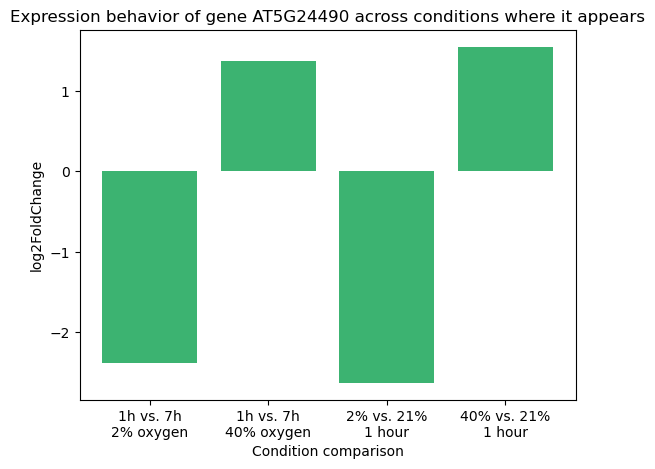

In [33]:
fig, ax = plt.subplots()

ax.bar([parsable_condition_names[k] for k in gene_of_interest_behaviors.keys()], gene_of_interest_behaviors.values(), color='mediumseagreen')
ax.set_xlabel('Condition comparison')
ax.set_ylabel('log2FoldChange')
ax.set_title(f'Expression behavior of gene {gene_of_interest} across conditions where it appears')

Save out:

In [34]:
all_comp_opposites = get_arabidopsis_descriptions(list(all_opposite), annotation_metadata)
all_comp_opposites.to_csv('../data/gene_lists_with_descriptions/all_comparisons_opposites_Araport11_TAIR10_19Mar2025.csv', index=True)